<a href="https://colab.research.google.com/github/tylerpan98/IMDB-comment-Sentiment-Analysis/blob/main/Semantic_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/semantic_analysis/


/content/drive/MyDrive/semantic_analysis


In [4]:
data = pd.read_csv('IMDB Dataset.csv')

In [9]:
import numpy as np
import pandas as pd
import string
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense
import nltk
from nltk.corpus import stopwords
import contractions
import spacy


In [10]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
data['review'].duplicated().sum()

418

In [12]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

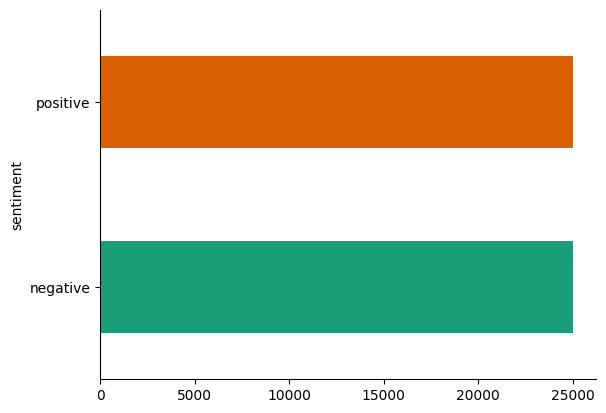

In [13]:
data.groupby('sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
data = data.drop_duplicates()

In [15]:
data.shape

(49582, 2)

In [16]:
from bs4 import BeautifulSoup

def remove_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [17]:
data['review'] = data['review'].apply(remove_html_tags)


<ipython-input-16-273477798574>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [18]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

data['review'] = data['review'].apply(remove_punctuation)


In [19]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stop_words(text):
    return ' '.join(word for word in text.split() if word.lower() not in stop_words)

data['review'] = data['review'].apply(remove_stop_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['review'] = data['review'].apply(remove_emoji)


In [21]:
def expand_contractions(text):
    return contractions.fix(text)

data['review'] = data['review'].apply(expand_contractions)


In [22]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join(token.lemma_ for token in doc if token.lemma_ != '-PRON-')


data['review'] = data['review'].apply(lemmatize_text)


In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['review'])

sequences = tokenizer.texts_to_sequences(data['review'])

data['review'] = data['review'].apply(lambda x: ' '.join(tokenizer.sequences_to_texts(tokenizer.texts_to_sequences([x]))))

data['review'] = [tokenizer.sequences_to_texts([seq])[0].split() for seq in sequences]

In [24]:
data['sentiment'] = data['sentiment'].replace('positive', 1)
data['sentiment'] = data['sentiment'].replace('negative', 0)

In [25]:
data

,review,sentiment
0,"[one, reviewer, mention, watch, 1, oz, episode...",1
1,"[wonderful, little, production, filming, techn...",1
2,"[think, wonderful, way, spend, time, hot, summ...",1
3,"[basically, there, be, family, little, boy, ja...",0
4,"[petter, matteis, love, time, money, visually,...",1
...,...,...
49995,"[think, movie, right, good, job, be, not, crea...",1
49996,"[bad, plot, bad, dialogue, bad, act, idiotic, ...",0
49997,"[catholic, teach, parochial, elementary, schoo...",0
49998,"[i, be, go, disagree, previous, comment, side,...",0


In [26]:
from sklearn.model_selection import train_test_split

x = data['review']
y = data['sentiment']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state = 42)


In [27]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [28]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(x_train)

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

x_train_padded = pad_sequences(x_train_sequences, maxlen=100)
x_test_padded = pad_sequences(x_test_sequences, maxlen=100)

In [29]:
print("Shape of x_train_tfidf:", x_train_padded.shape)
print("Shape of x_test_tfidf:", x_test_padded.shape)

Shape of x_train_tfidf: (34707, 100)
Shape of x_test_tfidf: (14875, 100)


In [45]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM,  BatchNormalization


In [75]:
cnn_model = Sequential()
cnn_model.add(Embedding(1000, 100, input_length=100))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(MaxPooling1D(pool_size=4))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(2, activation='sigmoid'))
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [72]:
lstm_model = Sequential()
lstm_model.add(Embedding(1000, 100, input_length=100))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(Dropout(0.5))
lstm_model.add(LSTM(128))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dense(2, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
lstm_history = lstm_model.fit(x_train_padded, y_train, epochs=10, batch_size=200, validation_data=(x_test_padded, y_test))

Epoch 1/10
174/174 [==============================] - 256s 1s/step - loss: 0.4587 - accuracy: 0.7789 - val_loss: 0.3541 - val_accuracy: 0.8444
Epoch 2/10
174/174 [==============================] - 247s 1s/step - loss: 0.3404 - accuracy: 0.8572 - val_loss: 0.3445 - val_accuracy: 0.8481
Epoch 3/10
174/174 [==============================] - 249s 1s/step - loss: 0.3248 - accuracy: 0.8651 - val_loss: 0.3387 - val_accuracy: 0.8504
Epoch 4/10
174/174 [==============================] - 289s 2s/step - loss: 0.3095 - accuracy: 0.8706 - val_loss: 0.3408 - val_accuracy: 0.8547
Epoch 5/10
174/174 [==============================] - 400s 2s/step - loss: 0.3011 - accuracy: 0.8736 - val_loss: 0.3433 - val_accuracy: 0.8522
Epoch 6/10
174/174 [==============================] - 403s 2s/step - loss: 0.2948 - accuracy: 0.8779 - val_loss: 0.3433 - val_accuracy: 0.8468
Epoch 7/10
174/174 [==============================] - 413s 2s/step - loss: 0.2860 - accuracy: 0.8819 - val_loss: 0.3511 - val_accuracy: 0.8491

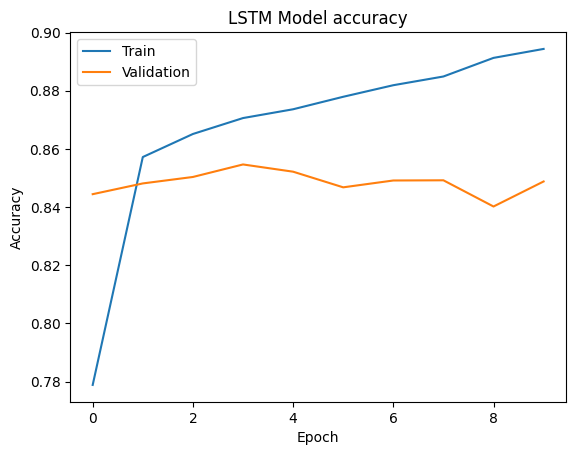

In [74]:
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('LSTM Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [76]:
cnn_history = cnn_model.fit(x_train_padded, y_train, epochs=10, batch_size=200, validation_data=(x_test_padded, y_test))


Epoch 1/10
174/174 [==============================] - 94s 530ms/step - loss: 0.4586 - accuracy: 0.7721 - val_loss: 0.3354 - val_accuracy: 0.8547
Epoch 2/10
174/174 [==============================] - 70s 403ms/step - loss: 0.3251 - accuracy: 0.8646 - val_loss: 0.3242 - val_accuracy: 0.8589
Epoch 3/10
174/174 [==============================] - 68s 389ms/step - loss: 0.2955 - accuracy: 0.8783 - val_loss: 0.3246 - val_accuracy: 0.8586
Epoch 4/10
174/174 [==============================] - 70s 403ms/step - loss: 0.2575 - accuracy: 0.8975 - val_loss: 0.3346 - val_accuracy: 0.8592
Epoch 5/10
174/174 [==============================] - 70s 401ms/step - loss: 0.1953 - accuracy: 0.9265 - val_loss: 0.3581 - val_accuracy: 0.8503
Epoch 6/10
174/174 [==============================] - 83s 480ms/step - loss: 0.1242 - accuracy: 0.9590 - val_loss: 0.4321 - val_accuracy: 0.8482
Epoch 7/10
174/174 [==============================] - 113s 650ms/step - loss: 0.0610 - accuracy: 0.9819 - val_loss: 0.5529 - val_a

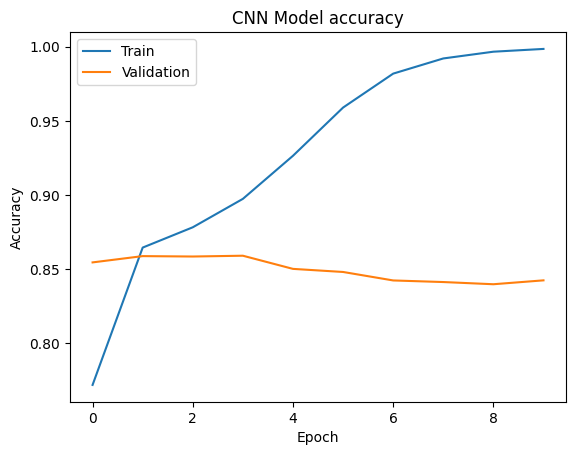

In [77]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [80]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

lstm_pred = lstm_model.predict(x_test_padded)

lstm_pred = (lstm_pred > 0.5).astype('int')

lstm_report = classification_report(y_test, lstm_pred, output_dict=True)
lstm_report = pd.DataFrame(lstm_report).transpose()
lstm_report

465/465 [==============================] - 69s 149ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.843825,0.854538,0.849148,7404.0
1,0.854430,0.842993,0.848673,7471.0
micro avg,0.849082,0.848739,0.848911,14875.0
macro avg,0.849127,0.848765,0.848910,14875.0
weighted avg,0.849151,0.848739,0.848909,14875.0
samples avg,0.848672,0.848739,0.848695,14875.0


In [82]:
cnn_pred = cnn_model.predict(x_test_padded)

cnn_pred = (cnn_pred > 0.5).astype('int')

cnn_report = classification_report(y_test, cnn_pred, output_dict=True)
cnn_report = pd.DataFrame(cnn_report).transpose()
cnn_report


465/465 [==============================] - 11s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
0,0.856399,0.821583,0.838630,7404.0
1,0.830245,0.863472,0.846532,7471.0
micro avg,0.842735,0.842622,0.842678,14875.0
macro avg,0.843322,0.842528,0.842581,14875.0
weighted avg,0.843263,0.842622,0.842599,14875.0
samples avg,0.842487,0.842622,0.842532,14875.0
